In [ ]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (7,5)
import seaborn as sns
colors = sns.color_palette("colorblind")

In [ ]:
# Define custom dash patterns for each line without names
custom_dashes = [
    (1, 0),           # Solid
    (1, 1),           # Dotted
    (4, 2),           # Dashed
    (3, 2, 1, 2),     # Dash-Dot
    (5, 2, 1, 2, 1, 2),  # Dash-Dot-Dot
    (8, 2),           # Long Dashes
    (2, 4),           # Loosely Dashed
    (5, 4, 1, 4),     # Sparse Dash-Dot
    (6, 4, 1, 4, 1, 4),  # Sparse Dash-Dot-Dot
    (1, 4),           # Loosely Dotted
    (4, 2, 1, 2, 1, 2),  # Dashed with Dots
    (2, 4, 1, 4, 2, 4)   # Custom Pattern 1
]

In [ ]:
def generate_random_symmetric_function(N):
    # Generate a random upper triangular matrix
    random_matrix = np.random.rand(N, N)

    # Make it symmetric
    symmetric_matrix = 0.5*(random_matrix + random_matrix.T)

    # Create a JAX array from the symmetric matrix
    B = jnp.array(symmetric_matrix)

    return B


def generate_random_vector(N):
    return jnp.array(np.random.rand(N))


def averager(Array_x, Array_y, num_iterations):
    DenVec = jnp.cumsum(jnp.array([1 for i in range(num_iterations+1)])).reshape((num_iterations+1,1))

    AvgArray_x = np.cumsum(Array_x,axis=0)/DenVec
    AvgArray_y = np.cumsum(Array_y,axis=0)/DenVec
    return (AvgArray_x, AvgArray_y)

In [ ]:
def lossBilinearBanal(x, y, loss_param):
    return jnp.dot(x, y)

def lossBilinear(x, y, loss_param):
    B = loss_param[0]
    return jnp.dot(jnp.dot(x, B), y)

def lossBilinearFull(x, y, loss_param):
    A = loss_param[0]
    B = loss_param[1]
    C = loss_param[2]
    return 0.5*jnp.dot(jnp.dot(x, A), x) + jnp.dot(jnp.dot(x, B), y) - 0.5*jnp.dot(jnp.dot(y, C), y)

def lossHighNonlinear_1(x, y, loss_param):
    return jnp.sum(x*(y-0.45) + phi_1(x) - phi_1(y))

def phi_1(z):
    return 0.25*jnp.power(z, 2) - 0.5*jnp.power(z, 4)  + (1/6)*jnp.power(z, 6)

def lossHighNonlinear_2(x, y, loss_param):
    epsilon = loss_param[0]
    return jnp.sum(x*y - epsilon*phi_2(y))

def phi_2(z):
    return 0.5*jnp.power(z, 2) - 0.25*jnp.power(z, 4)

def norm_iterates(x, y):
    return jnp.linalg.norm(x,axis=1) + jnp.linalg.norm(y,axis=1)

def many_norm_iterates(x, y):
    norm_iteratess = np.zeros((np.shape(x)[0],np.shape(x)[1]))
    for i in range(0,np.shape(x)[0]):
      norm_iteratess[i,:] = jnp.linalg.norm(x[i,:,:],axis=1) + jnp.linalg.norm(y[i,:,:],axis=1)

    return norm_iteratess

In [ ]:
def GDA(loss, loss_param, x_init, y_init, eta, num_iterations):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)

        x = x - eta * grad_x
        y = y + eta * grad_y  # Gradient Ascent step

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def EG(loss, loss_param, x_init, y_init, eta, rho, num_iterations):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        increment_x = grad_loss_x(x - rho*grad_x, y + rho*grad_y, loss_param)
        increment_y = grad_loss_y(x - rho*grad_x, y + rho*grad_y, loss_param)

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y



def NEG(loss, loss_param, x_init, y_init, eta, rho, num_iterations):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)

        increment_x = grad_loss_x(x - rho*grad_x/jnp.linalg.norm(grad_x), y + rho*grad_y/jnp.linalg.norm(grad_y), loss_param)
        increment_y = grad_loss_y(x - rho*grad_x/jnp.linalg.norm(grad_x), y + rho*grad_y/jnp.linalg.norm(grad_y), loss_param)

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def FNEG(loss, loss_param, x_init, y_init, eta, rho, num_iterations):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)

        normF = jnp.sqrt(jnp.linalg.norm(grad_x)**2 + jnp.linalg.norm(grad_y)**2)

        increment_x = grad_loss_x(x - rho*grad_x/normF, y + rho*grad_y/normF, loss_param)
        increment_y = grad_loss_y(x - rho*grad_x/normF, y + rho*grad_y/normF, loss_param)

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y

def HGD_Old(loss, loss_param, x_init, y_init, eta, num_iterations):

    # Define a function to compute the gradient of loss(x, y) with respect to y
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to y
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # This is the Hamiltonian which is the function that the HGD tries to minimize. It is the sum of the norm squared of the gradients wrt x and y of the loss.
    def lossH(x, y, param_loss):
          grad_x = grad_loss_x(x, y, loss_param)
          grad_y = grad_loss_y(x, y, loss_param)
          return 0.5*(jnp.linalg.norm(grad_x, ord=2)**2 + jnp.linalg.norm(grad_y, ord=2)**2)

    # Define a function to compute the gradient of lossHG(x, y) with respect to x
    grad_lossH_x = jax.jit(jax.grad(lossH, argnums=0))

    # Define a function to compute the gradient of lossHG(x, y) with respect to y
    grad_lossH_y = jax.jit(jax.grad(lossH, argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_lossH_x(x, y, loss_param)
        grad_y = grad_lossH_y(x, y, loss_param)
        x = x - eta * grad_x
        y = y - eta * grad_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def HGD(loss, loss_param, x_init, y_init, eta, num_iterations):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * (jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y))
        y = y - eta * (jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SignHGD(loss, loss_param, x_init, y_init, eta, num_iterations):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * jnp.sign((jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y)))
        y = y - eta * jnp.sign((jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y)))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SignHGD_DecrLR(loss, loss_param, x_init, y_init, eta, num_iterations):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - (eta/np.sqrt(k+1)) * jnp.sign((jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y)))
        y = y - (eta/np.sqrt(k+1)) * jnp.sign((jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y)))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def NHGD(loss, loss_param, x_init, y_init, eta, num_iterations):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * (jnp.dot(hess_xx,grad_x/jnp.linalg.norm(grad_x)) + jnp.dot(hess_xy,grad_y/jnp.linalg.norm(grad_y)))
        y = y - eta * (jnp.dot(hess_xy,grad_x/jnp.linalg.norm(grad_x)) + jnp.dot(hess_yy,grad_y/jnp.linalg.norm(grad_y)))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def FNHGD(loss, loss_param, x_init, y_init, eta, num_iterations):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    for _ in range(num_iterations):
        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        normF = jnp.sqrt(jnp.linalg.norm(grad_x)**2 + jnp.linalg.norm(grad_y)**2)

        x = x - eta * (jnp.dot(hess_xx,grad_x/normF) + jnp.dot(hess_xy,grad_y/normF))
        y = y - eta * (jnp.dot(hess_xy,grad_x/normF) + jnp.dot(hess_yy,grad_y/normF))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y

In [ ]:
# Gradient Descent-Ascent function with trajectory recording
def SGDA(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))


        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        x = x - eta * grad_x
        y = y + eta * grad_y  # Gradient Ascent step

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        increment_x = grad_loss_x(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_x
        increment_y = grad_loss_y(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_y

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y

def SNEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        increment_x = grad_loss_x(x - rho*(grad_x/jnp.linalg.norm(grad_x)), y + rho*(grad_y/jnp.linalg.norm(grad_y)), loss_param) + Z_x
        increment_y = grad_loss_y(x - rho*(grad_x/jnp.linalg.norm(grad_x)), y + rho*(grad_y/jnp.linalg.norm(grad_y)), loss_param) + Z_y

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SFNEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        normF = jnp.sqrt(jnp.linalg.norm(grad_x)**2 + jnp.linalg.norm(grad_y)**2)

        increment_x = grad_loss_x(x - rho*(grad_x/normF), y + rho*(grad_y/normF), loss_param) + Z_x
        increment_y = grad_loss_y(x - rho*(grad_x/normF), y + rho*(grad_y/normF), loss_param) + Z_y

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * (jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y))
        y = y - eta * (jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y



def SNHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * (jnp.dot(hess_xx,grad_x/jnp.linalg.norm(grad_x)) + jnp.dot(hess_xy,grad_y/jnp.linalg.norm(grad_y)))
        y = y - eta * (jnp.dot(hess_xy,grad_x/jnp.linalg.norm(grad_x)) + jnp.dot(hess_yy,grad_y/jnp.linalg.norm(grad_y)))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y



def SFNHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        normF = jnp.sqrt(jnp.linalg.norm(grad_x)**2 + jnp.linalg.norm(grad_y)**2)

        x = x - eta * (jnp.dot(hess_xx,grad_x/normF) + jnp.dot(hess_xy,grad_y/normF))
        y = y - eta * (jnp.dot(hess_xy,grad_x/normF) + jnp.dot(hess_yy,grad_y/normF))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


In [ ]:
def SEGs(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)


def SHGDs(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)

In [ ]:
"""
# Example:

x_init = jnp.array([0.5,0.5,0.5,0.5])
y_init = jnp.array([0.5,0.5,0.5,0.5])

B = jnp.array([[2.0, 0.0, 1.0, 0.0],
               [0.0, 3.0, 0.0, 1.0],
               [1.0, 0.0, 4.0, 0.0],
               [0.0, 1.0, 0.0, 5.0]])
"""

'\n# Example:\n\nx_init = jnp.array([0.5,0.5,0.5,0.5])\ny_init = jnp.array([0.5,0.5,0.5,0.5])\n\nB = jnp.array([[2.0, 0.0, 1.0, 0.0],\n               [0.0, 3.0, 0.0, 1.0],\n               [1.0, 0.0, 4.0, 0.0],\n               [0.0, 1.0, 0.0, 5.0]])\n'

In [ ]:
eigval = 1.0
a = 3.0
eta = 1e-2
num_iterations = 1000
sigma = 1e-1
scale = 1

rho1 = -1
rho2 = (a**2 + eigval**2 - a)/(eigval**2-a**2)
rho3 = 1/(a + eigval)
rho4 = -5

A = jnp.array([[a, 0.0],
               [0.0, a]])

B = jnp.array([[eigval, 0.0],
               [0.0, eigval]])

C = jnp.array([[a, 0.0],
               [0.0, a]])

x_init = jnp.array([1.0, 1.0])*scale
y_init = jnp.array([1.0, 1.0])*scale


loss_param = [A, B, C]


loss = lossBilinearFull

In [ ]:
print(B)

# Calculate eigenvalues
eigenvalues = jax.numpy.linalg.eigvals(B)

print("Eigenvalues:", eigenvalues)

[[1. 0.]
 [0. 1.]]
Eigenvalues: [1.+0.j 1.+0.j]


In [ ]:
loss_val = loss(x_init, y_init, loss_param)
grad_loss_x = jax.jit(jax.grad(loss, argnums=0))
grad_loss_y = jax.jit(jax.grad(loss, argnums=1))
normgrad_x = jnp.linalg.norm(grad_loss_x(x_init, y_init, loss_param))
normgrad_y = jnp.linalg.norm(grad_loss_y(x_init, y_init, loss_param))
print("Grad_x Norm ", normgrad_x)
print("Grad_y Norm ", normgrad_y)
print("Norm F ", jnp.sqrt(normgrad_x**2 + normgrad_y**2))
print("Loss:", loss_val)

Grad_x Norm  5.656854249492381
Grad_y Norm  2.8284271247461903
Norm F  6.324555320336759
Loss: 2.0


In [ ]:
seeds = [1,2,3,4,5]

In [ ]:
GDAs_x, GDAs_y  = SEGs(loss, loss_param, x_init, y_init, eta, 0, sigma, num_iterations, seeds)
EG1s_x, EG1s_y  = SEGs(loss, loss_param, x_init, y_init, eta, rho1, sigma, num_iterations, seeds)
EG2s_x, EG2s_y  = SEGs(loss, loss_param, x_init, y_init, eta, rho2, sigma, num_iterations, seeds)
EG3s_x, EG3s_y  = SEGs(loss, loss_param, x_init, y_init, eta, rho3, sigma, num_iterations, seeds)
EG4s_x, EG4s_y  = SEGs(loss, loss_param, x_init, y_init, eta, rho4, sigma, num_iterations, seeds)
HGDs_x, HGDs_y =  SHGDs(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seeds)

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5


In [ ]:
GDAs_x = np.array(GDAs_x)
GDAs_y= np.array(GDAs_y)
EG1s_x= np.array(EG1s_x)
EG1s_y= np.array(EG1s_y)
EG2s_x= np.array(EG2s_x)
EG2s_y= np.array(EG2s_y)
EG3s_x= np.array(EG3s_x)
EG3s_y= np.array(EG3s_y)
EG4s_x= np.array(EG4s_x)
EG4s_y= np.array(EG4s_y)
HGDs_x= np.array(HGDs_x)
HGDs_y= np.array(HGDs_y)

In [ ]:
avg_GDA_x = np.mean(GDAs_x,axis=0)
avg_GDA_y = np.mean(GDAs_y,axis=0)

avg_EG1_x = np.mean(EG1s_x,axis=0)
avg_EG1_y = np.mean(EG1s_y,axis=0)

avg_EG2_x = np.mean(EG2s_x,axis=0)
avg_EG2_y = np.mean(EG2s_y,axis=0)

avg_EG3_x = np.mean(EG3s_x,axis=0)
avg_EG3_y = np.mean(EG3s_y,axis=0)

avg_EG4_x = np.mean(EG4s_x,axis=0)
avg_EG4_y = np.mean(EG4s_y,axis=0)

avg_HGD_x = np.mean(HGDs_x,axis=0)
avg_HGD_y = np.mean(HGDs_y,axis=0)

In [ ]:
ni_GDA = many_norm_iterates(GDAs_x, GDAs_y)
ni_EG1 = many_norm_iterates(EG1s_x, EG1s_y)
ni_EG2 = many_norm_iterates(EG2s_x, EG2s_y)
ni_EG3 = many_norm_iterates(EG3s_x, EG3s_y)
ni_EG4 = many_norm_iterates(EG4s_x, EG4s_y)
ni_HGD = many_norm_iterates(HGDs_x, HGDs_y)

In [ ]:
avg_norm_iter_GDA = np.mean(ni_GDA,axis=0)
std_norm_iter_GDA = np.std(ni_GDA,axis=0)

avg_norm_iter_EG1 = np.mean(ni_EG1,axis=0)
std_norm_iter_EG1 = np.std(ni_EG1,axis=0)

avg_norm_iter_EG2 = np.mean(ni_EG2,axis=0)
std_norm_iter_EG2 = np.std(ni_EG2,axis=0)

avg_norm_iter_EG3 = np.mean(ni_EG3,axis=0)
std_norm_iter_EG3 = np.std(ni_EG3,axis=0)

avg_norm_iter_EG4 = np.mean(ni_EG4,axis=0)
std_norm_iter_EG4 = np.std(ni_EG4,axis=0)

avg_norm_iter_HGD = np.mean(ni_HGD,axis=0)
std_norm_iter_HGD = np.std(ni_HGD,axis=0)

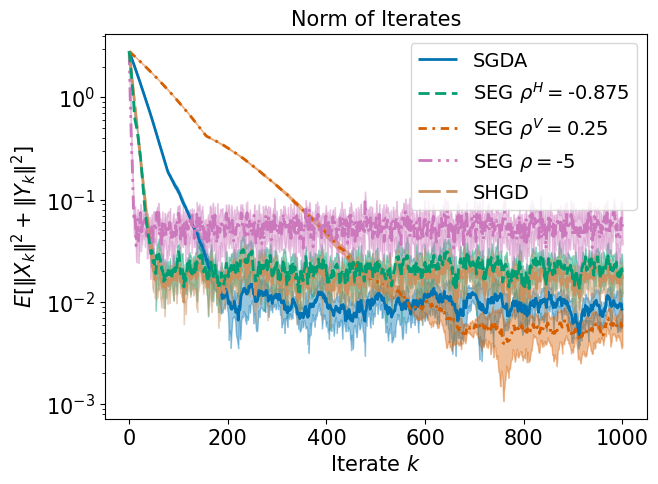

In [ ]:
plt.figure()
# We plot
line_1, = plt.plot(avg_norm_iter_GDA, color = colors[0],linewidth=2,linestyle='-', dashes=custom_dashes[0])
line_4, = plt.plot(avg_norm_iter_EG3, color = colors[3],linewidth=2,linestyle='-', dashes=custom_dashes[3])
line_5, = plt.plot(avg_norm_iter_EG4, color = colors[4],linewidth=2,linestyle='-', dashes=custom_dashes[4])
line_6, = plt.plot(avg_norm_iter_HGD, color = colors[5],linewidth=2,linestyle='-', dashes=custom_dashes[5])
line_3, = plt.plot(avg_norm_iter_EG2, color = colors[2],linewidth=2,linestyle='-', dashes=custom_dashes[2])

plt.fill_between( np.arange(0, num_iterations + 1), avg_norm_iter_GDA - 1*std_norm_iter_GDA, avg_norm_iter_GDA + 1*std_norm_iter_GDA,
                 color=colors[0], alpha=0.4)


plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG2 - 1*std_norm_iter_EG2, avg_norm_iter_EG2 + 1*std_norm_iter_EG2,
                 color=colors[2], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG3 - 1*std_norm_iter_EG3, avg_norm_iter_EG3 + 1*std_norm_iter_EG3,
                 color=colors[3], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG4 - 1*std_norm_iter_EG4, avg_norm_iter_EG4 + 1*std_norm_iter_EG4,
                 color=colors[4], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_HGD - 1*std_norm_iter_HGD, avg_norm_iter_HGD + 1*std_norm_iter_HGD,
                 color=colors[5], alpha=0.4)

plt.legend([line_1, line_3, line_4, line_5, line_6], ['SGDA', r'SEG $\rho^{H}= $' + str(rho2), r'SEG $\rho^{V}= $' + str(rho3), r'SEG $\rho= $' + str(rho4), 'SHGD'])
plt.title("Norm of Iterates",fontsize=15)
plt.xlabel(r'Iterate $k$',fontsize=15)
plt.ylabel(r'$E[\|X_k\|^2 + \|Y_k\|^2]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()